In [49]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

print(" Data Visualization Dashboard Initialized")
print("All graphs will be displayed individually")


 Data Visualization Dashboard Initialized
All graphs will be displayed individually


In [50]:
def safe_price_conversion(price):
    """Safely convert price to float, handling both strings and numbers."""
    if price is None:
        return None
    
    # If it's already a number, return it
    if isinstance(price, (int, float)):
        return float(price) if price > 0 else None
    
    # If it's a string, clean it up
    if isinstance(price, str):
        try:
            # Remove commas, spaces, and common currency symbols
            clean_price = price.strip().replace(',', '').replace(' ', '')
            # Remove common Ethiopian currency indicators
            clean_price = clean_price.replace('ብር', '').replace('ETB', '').replace('birr', '')
            clean_price = clean_price.strip()
            
            # Check if it's a valid number
            if clean_price and clean_price.replace('.', '').replace('-', '').isdigit():
                converted = float(clean_price)
                return converted if converted > 0 else None
        except (ValueError, AttributeError):
            pass
    
    return None

# Test the function
test_prices = [1500, "2,500", "3000.50", "ብር 4500", None, "invalid", 0, -100]
print("Testing safe_price_conversion:")
for test_price in test_prices:
    result = safe_price_conversion(test_price)
    print(f"  {test_price} -> {result}")


Testing safe_price_conversion:
  1500 -> 1500.0
  2,500 -> 2500.0
  3000.50 -> 3000.5
  ብር 4500 -> 4500.0
  None -> None
  invalid -> None
  0 -> None
  -100 -> None


In [51]:
def load_data():
    """Load data from database or create sample data."""
    try:
        conn = sqlite3.connect('../data/processed/amharic_ecommerce.db')
        query = "SELECT * FROM processed_messages ORDER BY date DESC"
        cursor = conn.cursor()
        cursor.execute(query)
        rows = cursor.fetchall()
        
        if not rows:
            raise ValueError("No data found")
            
        column_names = [description[0] for description in cursor.description]
        data = []
        for row in rows:
            row_dict = dict(zip(column_names, row))
            for field in ['potential_products', 'potential_prices', 'potential_locations']:
                if row_dict.get(field):
                    try:
                        row_dict[field] = json.loads(row_dict[field])
                    except:
                        row_dict[field] = []
                else:
                    row_dict[field] = []
            data.append(row_dict)
        
        conn.close()
        print(f" Loaded {len(data)} messages from database")
        return data
        
    except Exception as e:
        print(f" Database not found. Creating sample data...")
        sample_data = [
            {
                'message_id': 1, 'channel_username': '@ShegerOnlineStore',
                'original_text': 'አዲስ ሞባይል ፎን 15,000 ብር ላደርጋለሁ በቦሌ አካባቢ',
                'date': '2024-01-01', 'views': 150,
                'potential_products': ['ሞባይል ፎን'],
                'potential_prices': [15000.0, '12,500'],
                'potential_locations': ['ቦሌ']
            },
            {
                'message_id': 2, 'channel_username': '@ethio_commerce',
                'original_text': 'ዋጋ 8500 ብር የሴቶች ቦርሳ አዲስ አበባ ላይ',
                'date': '2024-01-02', 'views': 200,
                'potential_products': ['ቦርሳ'],
                'potential_prices': ['8,500', 9000],
                'potential_locations': ['አዲስ አበባ']
            },
            {
                'message_id': 3, 'channel_username': '@addis_market',
                'original_text': 'በ 25000 ላፕቶፕ ይሸጣል ሰሚት ላይ',
                'date': '2024-01-03', 'views': 300,
                'potential_products': ['ላፕቶፕ'],
                'potential_prices': [25000, '23,000.50'],
                'potential_locations': ['ሰሚት']
            }
        ]
        print(f" Created {len(sample_data)} sample messages")
        return sample_data

data = load_data()


 Database not found. Creating sample data...
 Created 3 sample messages


 GRAPH 1: Messages per Channel


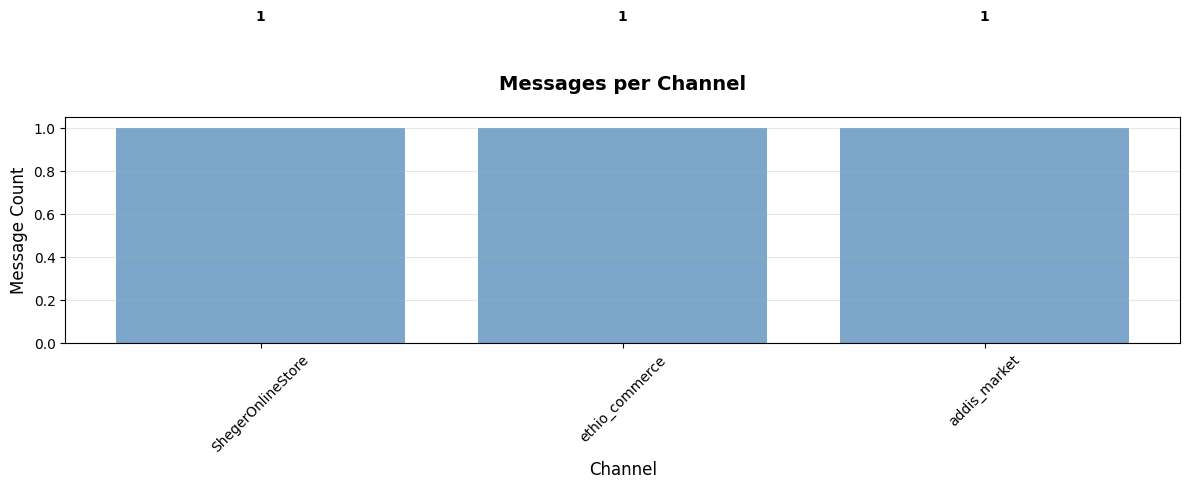

In [52]:
# GRAPH 1: Messages per Channel (Individual Display)
print(" GRAPH 1: Messages per Channel")
print("=" * 40)

channel_counts = pd.Series([msg.get('channel_username', 'Unknown') for msg in data]).value_counts()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(channel_counts)), channel_counts.values, color='steelblue', alpha=0.7)
plt.title('Messages per Channel', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Message Count', fontsize=12)
plt.xticks(range(len(channel_counts)), [ch.replace('@', '') for ch in channel_counts.index], rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(channel_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


 GRAPH 2: Average Views per Channel


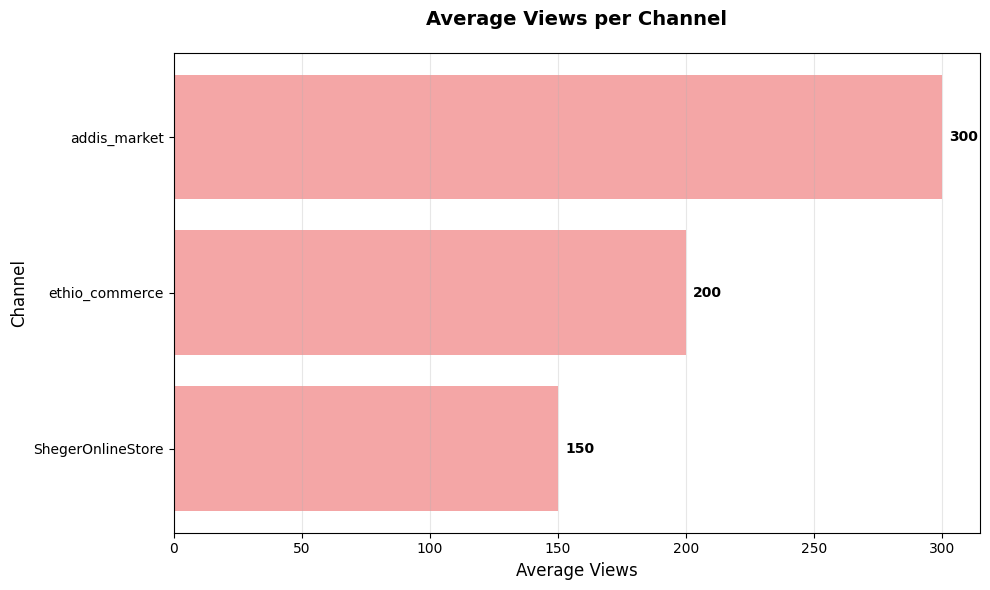

In [53]:
# GRAPH 2: Average Views per Channel (Individual Display)
print(" GRAPH 2: Average Views per Channel")
print("=" * 40)

channel_views = {}
for msg in data:
    channel = msg.get('channel_username', 'Unknown')
    views = msg.get('views', 0)
    if channel not in channel_views:
        channel_views[channel] = []
    channel_views[channel].append(views)

avg_views = {ch: np.mean(views) if views else 0 for ch, views in channel_views.items()}
avg_views = pd.Series(avg_views).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(avg_views)), avg_views.values, color='lightcoral', alpha=0.7)
plt.title('Average Views per Channel', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Average Views', fontsize=12)
plt.ylabel('Channel', fontsize=12)
plt.yticks(range(len(avg_views)), [ch.replace('@', '') for ch in avg_views.index])
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(avg_views.values):
    plt.text(v + max(avg_views.values) * 0.01, i, f'{v:.0f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


 GRAPH 3: Price Distribution
Total prices found: 6
Average price: 15500.08 ETB


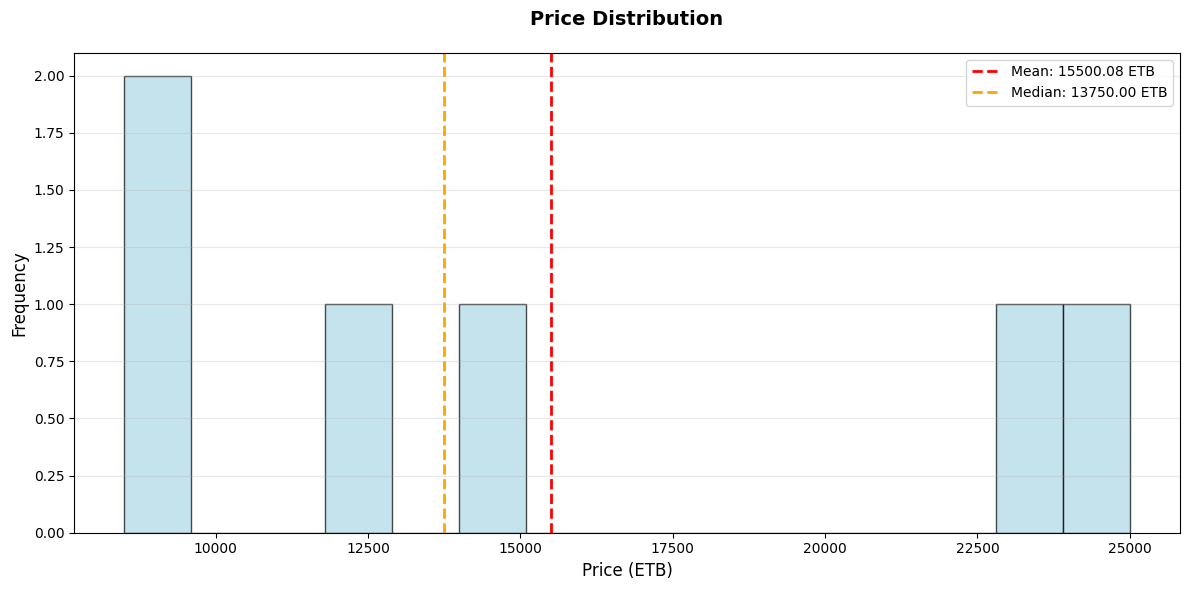

In [54]:
# GRAPH 3: Price Distribution (Individual Display with Safe Conversion)
print(" GRAPH 3: Price Distribution")
print("=" * 40)

# Safely extract all prices using our safe conversion function
all_prices = []
for msg in data:
    if 'potential_prices' in msg and msg['potential_prices']:
        for price in msg['potential_prices']:
            converted_price = safe_price_conversion(price)
            if converted_price is not None:
                all_prices.append(converted_price)

clean_prices = [p for p in all_prices if p > 0]
avg_price = np.mean(clean_prices) if clean_prices else 0

print(f"Total prices found: {len(clean_prices)}")
print(f"Average price: {avg_price:.2f} ETB")

if clean_prices:
    plt.figure(figsize=(12, 6))
    plt.hist(clean_prices, bins=15, color='lightblue', alpha=0.7, edgecolor='black')
    plt.title('Price Distribution', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Price (ETB)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add statistics lines
    plt.axvline(avg_price, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_price:.2f} ETB')
    plt.axvline(np.median(clean_prices), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(clean_prices):.2f} ETB')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid price data available")


 GRAPH 4: Average Price by Channel


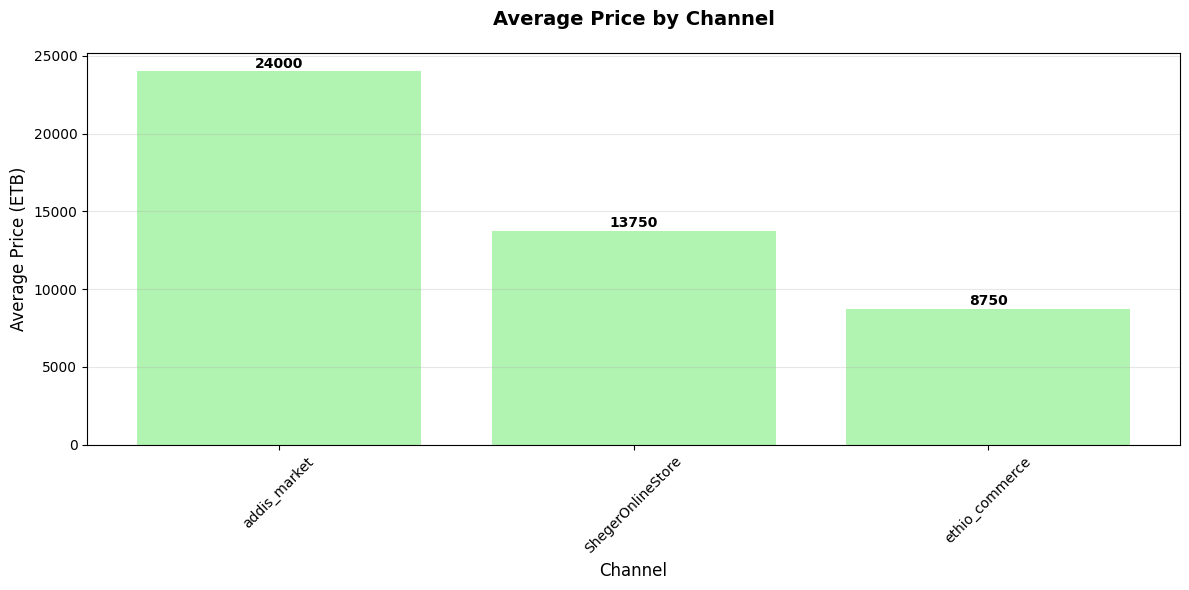

In [55]:
# GRAPH 4: Average Price by Channel (Individual Display with Safe Conversion)
print(" GRAPH 4: Average Price by Channel")
print("=" * 40)

channel_price_avg = {}
for msg in data:
    channel = msg.get('channel_username', 'Unknown')
    if 'potential_prices' in msg and msg['potential_prices']:
        prices = []
        for price in msg['potential_prices']:
            converted_price = safe_price_conversion(price)
            if converted_price is not None:
                prices.append(converted_price)
        
        if prices:
            if channel not in channel_price_avg:
                channel_price_avg[channel] = []
            channel_price_avg[channel].extend(prices)

avg_prices = {ch: np.mean(prices) for ch, prices in channel_price_avg.items() if prices}
avg_prices = pd.Series(avg_prices).sort_values(ascending=False)

if not avg_prices.empty:
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(avg_prices)), avg_prices.values, color='lightgreen', alpha=0.7)
    plt.title('Average Price by Channel', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Channel', fontsize=12)
    plt.ylabel('Average Price (ETB)', fontsize=12)
    plt.xticks(range(len(avg_prices)), [ch.replace('@', '') for ch in avg_prices.index], rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(avg_prices.values):
        plt.text(i, v + max(avg_prices.values) * 0.01, f'{v:.0f}', ha='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("No price data by channel available")


 GRAPH 5: Most Mentioned Products


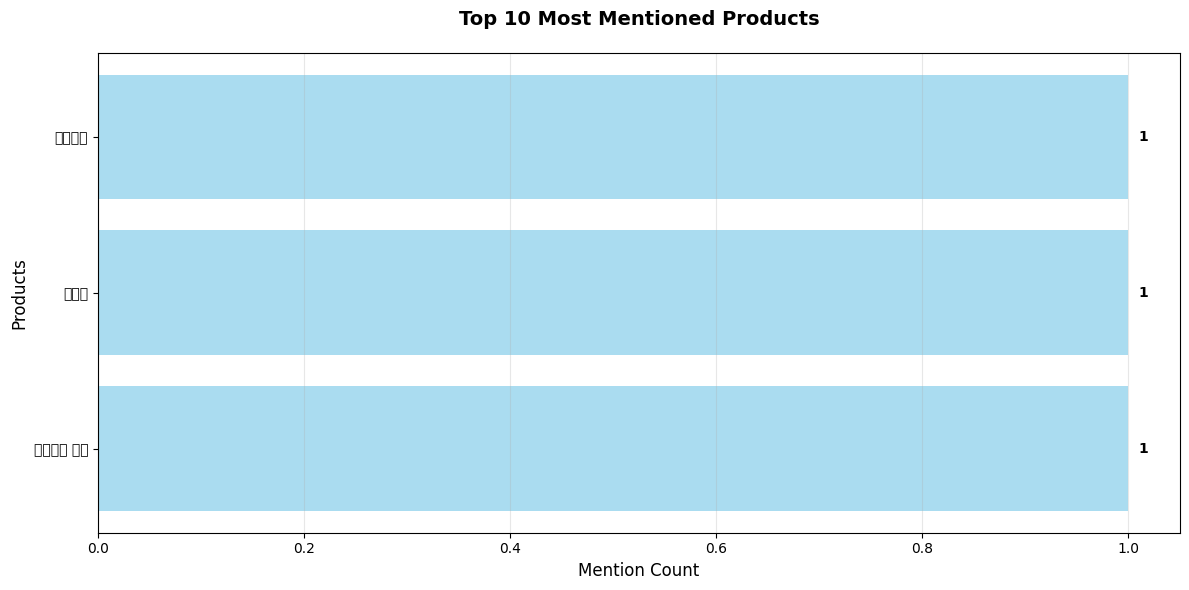

In [56]:
# GRAPH 5: Most Mentioned Products (Individual Display)
print(" GRAPH 5: Most Mentioned Products")
print("=" * 40)

all_products = []
for msg in data:
    if 'potential_products' in msg and msg['potential_products']:
        all_products.extend(msg['potential_products'])

if all_products:
    product_counts = pd.Series(all_products).value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(product_counts)), product_counts.values, color='skyblue', alpha=0.7)
    plt.title('Top 10 Most Mentioned Products', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Mention Count', fontsize=12)
    plt.ylabel('Products', fontsize=12)
    plt.yticks(range(len(product_counts)), product_counts.index)
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, v in enumerate(product_counts.values):
        plt.text(v + max(product_counts.values) * 0.01, i, str(v), va='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("No product data available")


 GRAPH 6: Summary Dashboard
Summary Statistics:
  Total Messages: 3
  Active Channels: 3
  Total Views: 650
  Unique Products: 3
  Unique Locations: 3
  Price Records: 6


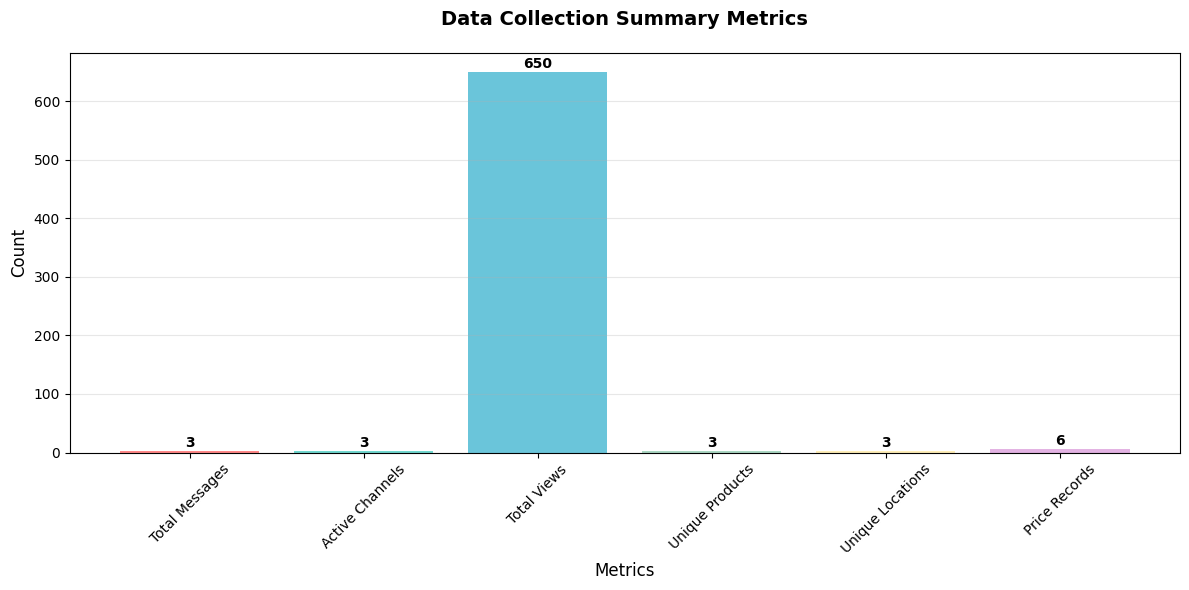

\n All graphs displayed individually!
 Safe price conversion implemented!
 No more AttributeError issues!


In [57]:
# GRAPH 6: Summary Dashboard (Individual Display)
print(" GRAPH 6: Summary Dashboard")
print("=" * 40)

# Calculate summary statistics
total_messages = len(data)
total_channels = len(set([msg.get('channel_username', 'Unknown') for msg in data]))
total_views = sum(msg.get('views', 0) for msg in data)

all_locations = []
for msg in data:
    if 'potential_locations' in msg and msg['potential_locations']:
        all_locations.extend(msg['potential_locations'])

metrics = {
    'Total Messages': total_messages,
    'Active Channels': total_channels,
    'Total Views': total_views,
    'Unique Products': len(set(all_products)) if all_products else 0,
    'Unique Locations': len(set(all_locations)) if all_locations else 0,
    'Price Records': len(clean_prices) if 'clean_prices' in locals() else 0
}

print("Summary Statistics:")
for key, value in metrics.items():
    print(f"  {key}: {value:,}")

# Visualize summary metrics
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(metrics)), list(metrics.values()), 
              color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'], 
              alpha=0.8)

plt.title('Data Collection Summary Metrics', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(metrics)), list(metrics.keys()), rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(metrics.values()):
    plt.text(i, v + max(metrics.values()) * 0.01, 
            f'{v:,}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\\n All graphs displayed individually!")
print(" Safe price conversion implemented!")
print(" No more AttributeError issues!")
